In [121]:
import csv
import os
from functools import partial
import json
import tqdm

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from gerrychain import (
   Election,
   Graph,
   MarkovChain,
   Partition,
   accept,
   constraints,
   updaters,
)
plt.style.use('ggplot')
from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

newdir = "./Outputs/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")

In [3]:
unique_label = "GEOID10"
pop_col = "TOT_POP"
district_col = "REMEDIAL_P"

graph_path = "./PA_VTD/PA_VTD.shp"

graph = Graph.from_file(graph_path, reproject = False)

graph.to_json("pa_json.json")

jgraph = Graph.from_json("pa_json.json")

In [4]:
df = gpd.read_file(graph_path)

In [5]:
df

,STATEFP10,COUNTYFP10,VTDST10,GEOID10,VTDI10,NAME10,NAMELSAD10,LSAD10,MTFCC10,FUNCSTAT10,...,F2014GOVR,2011_PLA_1,REMEDIAL_P,538CPCT__1,538DEM_PL,538GOP_PL,8THGRADE_1,area,perimeter,geometry
0,42,039,60,42039060,A,CAMBRIDGE SPRINGS Voting District,CAMBRIDGE SPRINGS Voting District,00,G5240,N,...,0,3,14,03,03,03,1,5.825700e+07,45771.53136,"POLYGON ((-80.11566499999999 41.762615, -80.11..."
1,42,039,510,42039510,A,TITUSVILLE WD 03,TITUSVILLE WD 03,00,G5240,N,...,957,3,14,03,03,03,1,9.689289e+07,39695.64227,"POLYGON ((-79.64411699999999 41.617206, -79.64..."
2,42,039,410,42039410,A,SPARTANSBURG Voting District,SPARTANSBURG Voting District,00,G5240,N,...,256,3,14,03,03,03,1,1.107861e+08,43178.68028,"POLYGON ((-79.77053699999999 41.833582, -79.77..."
3,42,039,100,42039100,A,CONNEAUT LAKE Voting District,CONNEAUT LAKE Voting District,00,G5240,N,...,696,3,14,03,03,03,1,6.599178e+07,33666.16493,"POLYGON ((-80.393242 41.635537, -80.393221 41...."
4,42,039,200,42039200,A,LINESVILLE Voting District,LINESVILLE Voting District,00,G5240,N,...,208,3,14,03,03,03,1,3.467810e+07,28677.18146,"POLYGON ((-80.49727799999999 41.66668, -80.496..."
5,42,039,430,42039430,A,SPRINGBORO Voting District,SPRINGBORO Voting District,00,G5240,N,...,250,3,14,03,03,03,1,1.206652e+08,46756.30323,"POLYGON ((-80.405857 41.849619, -80.4055489999..."
6,42,039,540,42039540,A,TOWNVILLE Voting District,TOWNVILLE Voting District,00,G5240,N,...,215,3,14,03,03,03,1,6.502989e+07,39251.19781,"POLYGON ((-79.90250899999999 41.713213, -79.90..."
7,42,109,110,42109110,A,MIDDLEBURG,MIDDLEBURG Voting District,V2,G5240,N,...,576,10,10,10,10,17,5,7.523266e+07,38638.01569,"POLYGON ((-77.125596 40.80296, -77.12462599999..."
8,42,109,80,42109080,A,Freeburg,Freeburg Voting District,V2,G5240,N,...,341,10,10,10,10,17,5,6.362305e+07,33223.11338,"POLYGON ((-77.01855399999999 40.768456, -77.01..."
9,42,109,30,42109030,A,BEAVERTOWN,BEAVERTOWN Voting District,V2,G5240,N,...,274,10,10,10,10,17,5,5.010558e+07,28639.76935,"POLYGON ((-77.198669 40.773218, -77.1984279999..."


In [6]:
list(df.columns.values)

['STATEFP10',
 'COUNTYFP10',
 'VTDST10',
 'GEOID10',
 'VTDI10',
 'NAME10',
 'NAMELSAD10',
 'LSAD10',
 'MTFCC10',
 'FUNCSTAT10',
 'ALAND10',
 'AWATER10',
 'INTPTLAT10',
 'INTPTLON10',
 'ATG12D',
 'ATG12R',
 'GOV10D',
 'GOV10R',
 'PRES12D',
 'PRES12O',
 'PRES12R',
 'SEN10D',
 'SEN10R',
 'T16ATGD',
 'T16ATGR',
 'T16PRESD',
 'T16PRESOTH',
 'T16PRESR',
 'T16SEND',
 'T16SENR',
 'USS12D',
 'USS12R',
 'GOV',
 'TS',
 'HISP_POP',
 'TOT_POP',
 'WHITE_POP',
 'BLACK_POP',
 'NATIVE_POP',
 'ASIAN_POP',
 'F2014GOVD',
 'F2014GOVR',
 '2011_PLA_1',
 'REMEDIAL_P',
 '538CPCT__1',
 '538DEM_PL',
 '538GOP_PL',
 '8THGRADE_1',
 'area',
 'perimeter',
 'geometry']

In [7]:
def num_splits(partition): # counting how many times a split is done to a county/block group/precinct because we don't want the split to be done to the country/block group/precinct
    df["current"] = df[unique_label].map(dict(partition.assignment))
    splits = sum(df.groupby("REMEDIAL_P")["current"].nunique() > 1)
    return splits

def avg_pop_dist(partition): # calculating average population deviation for each plan
    ideal_population = sum(partition["population"].values()) / len(
    partition
)
    total_deviation = sum([abs(v - ideal_population) for v in partition['population'].values()])
    return (total_deviation)/len(partition)

In [8]:
def pop_dist_pct(partition): # calculating percentage population deviation for each plan
    ideal_population = ideal_population = sum(partition["population"].values()) / len(
    partition)
    total_deviation = total_deviation = sum([abs(v - ideal_population) for v in partition['population'].values()])
    avg_dist = total_deviation/len(partition)
    return avg_dist/ideal_population

In [9]:
my_updaters = {
    "cut_edges": cut_edges,
    "population": updaters.Tally("TOT_POP", alias = "population"),
    "avg_pop_dist": avg_pop_dist,
    "pop_dist_pct" : pop_dist_pct,
    "area_land": updaters.Tally("ALAND10", alias = "area_land"),
    "area_water": updaters.Tally("AWATER10", alias = "area_water"),
    "Perimeter": updaters.Tally("perimeter", alias = "Perimeter"),
    "Area": updaters.Tally("area", alias = "Area"),
    "black_pop": updaters.Tally("BLACK_POP", alias="black_pop"),
    "hisp_pop": updaters.Tally("HISP_POP", alias="hisp_pop")
}

In [10]:
num_elections = 2

election_names = [
    "PRES12",
    "PRES16",
]

election_columns = [
    ["PRES12D", "PRES12R"],
    ["T16PRESD", "T16PRESR"],
]

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

In [13]:
election_updaters = {election.name: election for election in elections}

my_updaters.update(election_updaters)

num_dist = 18

initial_partition = Partition(jgraph, "REMEDIAL_P", my_updaters) # by typing in "CD," we are saying to put every county into the congressional district that they belong to

ideal_population = ideal_population = sum(initial_partition["population"].values()) / len(
    initial_partition
)

proposal = partial(
    recom, pop_col="TOT_POP", pop_target=ideal_population, epsilon=0.02, node_repeats=2
)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

In [18]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, 0.02),
        compactness_bound,  # single_flip_contiguous#no_more_discontiguous
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000,
)

In [19]:
pop_vec = []
cut_vec = []
mms_vec = []
egs_vec = []
pop_dist_vec = []
pop_pct_vec = []
splits = []
votes = [[],[],[]]
area_water = []
area_land=[]
pp_score=[]
area=[]
perimeter=[]
pp_score=[]
Area=[]
Perimeter=[]
B_pop=[]
H_pop=[]
pop=[]

t=0
for part in chain.with_progress_bar():
    splits.append(num_splits(part))
    

    pop_dist_vec.append(avg_pop_dist(part))
    pop.append((list(part["population"].values())))
    cut_vec.append(len(part["cut_edges"]))
    area_water.append(part["area_water"])
    area_land.append(part["area_land"])
    mms_vec.append([])
    egs_vec.append([])
    pop_pct_vec.append(pop_dist_pct(part))
    Area.append(part["Area"])
    Perimeter.append(part["Perimeter"])
    area.append(list(part["Area"].values()))
    perimeter.append(list(part["Perimeter"].values()))
    B_pop.append((list(part["black_pop"].values())))
    H_pop.append((list(part["hisp_pop"].values())))
    
    
   
    

    for elect in range(num_elections):
        votes[elect].append(sorted(part[election_names[elect]].percents("Democratic")))
        mms_vec[-1].append(mean_median(part[election_names[elect]]))
        egs_vec[-1].append(efficiency_gap(part[election_names[elect]]))



In [20]:
Area

[defaultdict(int,
             {14: 8709991853.736795,
              10: 25949589610.309307,
              11: 15736556398.43301,
              13: 25476424020.35249,
              18: 8640249014.568693,
              4: 1243808443.3134015,
              1: 1707869359.878601,
              9: 4014694669.987962,
              8: 2890347295.505798,
              12: 7441305456.781493,
              17: 7095273080.604998,
              7: 2253327702.237001,
              5: 575465595.0048405,
              15: 2331507195.2392683,
              6: 2396889468.4325,
              2: 171536673.10556993,
              3: 141602704.19763014,
              16: 778134261.5585803}),
 {14: 8709991853.736795,
  10: 7825318866.06449,
  11: 15736556398.43301,
  13: 25476424020.35249,
  18: 26764519758.81351,
  4: 1243808443.3134015,
  1: 1707869359.878601,
  9: 4014694669.987962,
  8: 2890347295.505798,
  12: 7441305456.781493,
  17: 7095273080.604998,
  7: 2253327702.237001,
  5: 575465595.0048405,
 

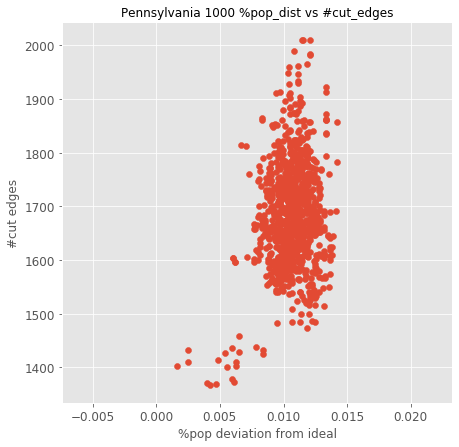

In [122]:
fig=plt.figure(figsize=(7,7))
plt.scatter(pop_pct_vec, cut_vec)
plt.title("Pennsylvania 1000 %pop_dist vs #cut_edges",fontsize=12)
plt.xlabel("%pop deviation from ideal", fontsize=12)
plt.ylabel("#cut edges", fontsize=12)
plt.yticks(fontsize =12)
plt.xticks(fontsize =12)
fig.savefig('PA_cut_edges_pop_deviation.png',dpi=300, bbox_inches='tight')

In [41]:
new_list_area=[]
for i in range(1000):
    new_list_area.append([item * (4*np.pi) for item in area[i]])

In [42]:
new_list_perimeter=[]
for i in range(1000):
    new_list_perimeter.append([item**2 for item in perimeter[i]])

In [43]:
pp_score=[]
for i in range(1000):
    pp_score.append([x/y for x,y in zip(new_list_area[i],new_list_perimeter[i])])

In [44]:
sum_pp_score=[]
for i in range(1000):
    sum_pp_score.append(sum(item for item in pp_score[i]))

In [45]:
average_pp_score=[]
for i in range(1000):
    average_pp_score.append(sum_pp_score[i]/18)

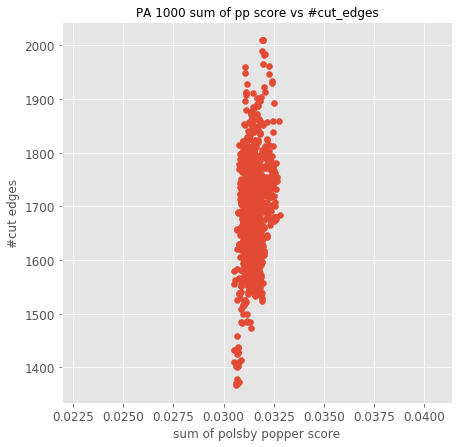

In [123]:
fig=plt.figure(figsize=(7,7))
plt.scatter(sum_pp_score, cut_vec)
plt.title("PA 1000 sum of pp score vs #cut_edges",fontsize=12)
plt.xlabel("sum of polsby popper score",fontsize=12)
plt.ylabel("#cut edges",fontsize=12)
plt.yticks(fontsize =12)
plt.xticks(fontsize =12)
fig.savefig('PA_sum_pp_score_cut_edges.png',dpi=300, bbox_inches='tight')

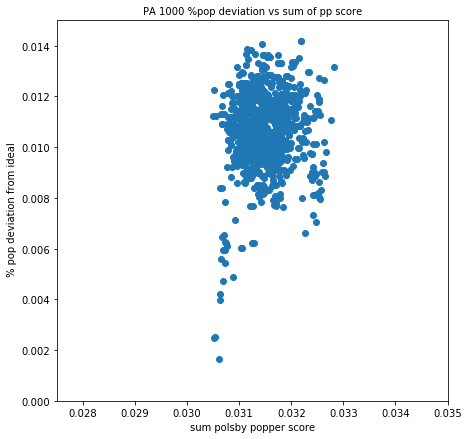

In [113]:
fig=plt.figure(figsize=(7,7))
plt.scatter(sum_pp_score, pop_pct_vec)
plt.title("PA 1000 %pop deviation vs sum of pp score",fontsize=10)
plt.xlabel("sum polsby popper score",fontsize=10)
plt.ylabel(" % pop deviation from ideal",fontsize=10)
plt.yticks(fontsize =10)
plt.xticks(fontsize =10)
plt.xlim(0.0275,0.035)
plt.ylim(0,0.015)
fig.savefig('PA_sum_pp_pop_deviation.png')

In [66]:
MM_pres12=[]
for i in range(1000):
    MM_pres12.append(abs(mms_vec[i][0]))

In [67]:
EG_pres12=[]
for i in range(1000):
    EG_pres12.append(abs(egs_vec[i][0]))

Text(0, 0.5, 'abs mean median gaps for election 12')

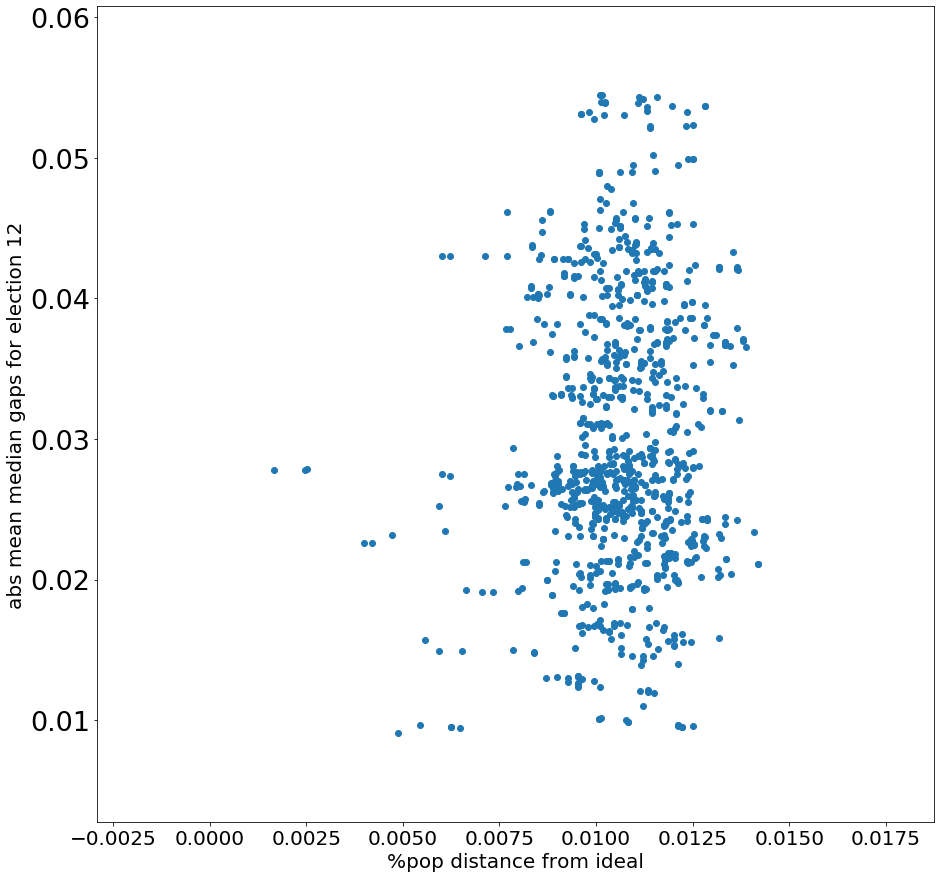

In [73]:
plt.figure(figsize=(15,15))
plt.scatter(pop_pct_vec, MM_pres12)
plt.yticks(fontsize =27)
plt.xticks(fontsize =20)

plt.xlabel("%pop distance from ideal",fontsize=20)
plt.ylabel("abs mean median gaps for election 12",fontsize=20)

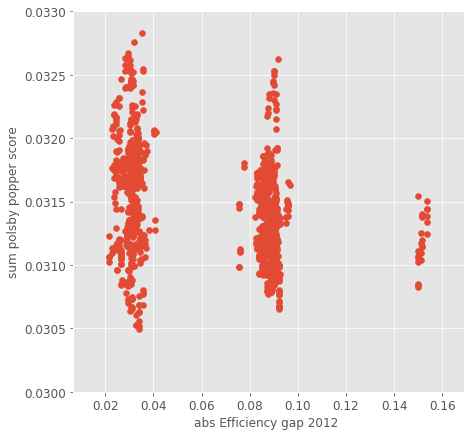

In [126]:
fig=plt.figure(figsize=(7,7))
plt.scatter(EG_pres12, sum_pp_score)
plt.yticks(fontsize =12)
plt.xticks(fontsize =12)
plt.ylim(0.03,0.033)
plt.xlabel("abs Efficiency gap 2012 ",fontsize=12)
plt.ylabel("sum polsby popper score",fontsize=12)
fig.savefig('PA_sum_pp_EG.png',dpi=300, bbox_inches='tight')

Text(0, 0.5, 'abs efficiency gaps for election 2012')

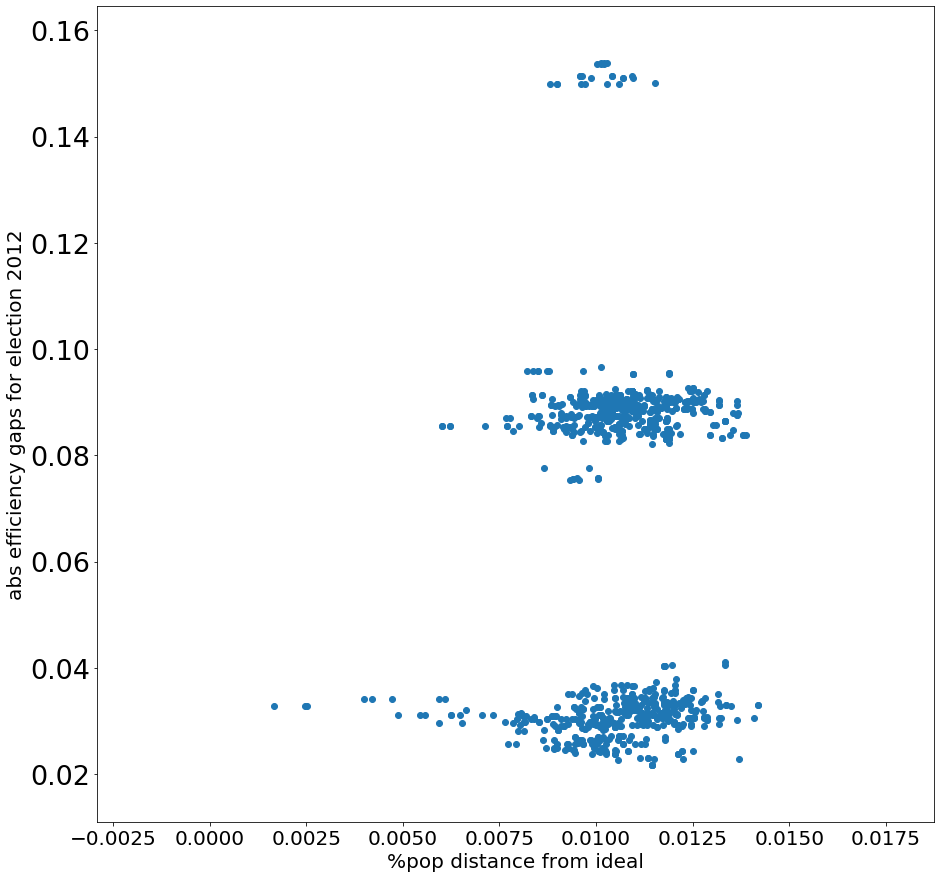

In [79]:
plt.figure(figsize=(15,15))
plt.scatter(pop_pct_vec, EG_pres12)
#plt.title("Iowa 1000 %pop_dist vs MM")
#plt.xlim(0,0.015)
plt.yticks(fontsize =27)
plt.xticks(fontsize =20)
plt.xlabel("%pop distance from ideal",fontsize=20)
plt.ylabel("abs efficiency gaps for election 2012",fontsize=20)

Text(0, 0.5, 'sum polsby popper score')

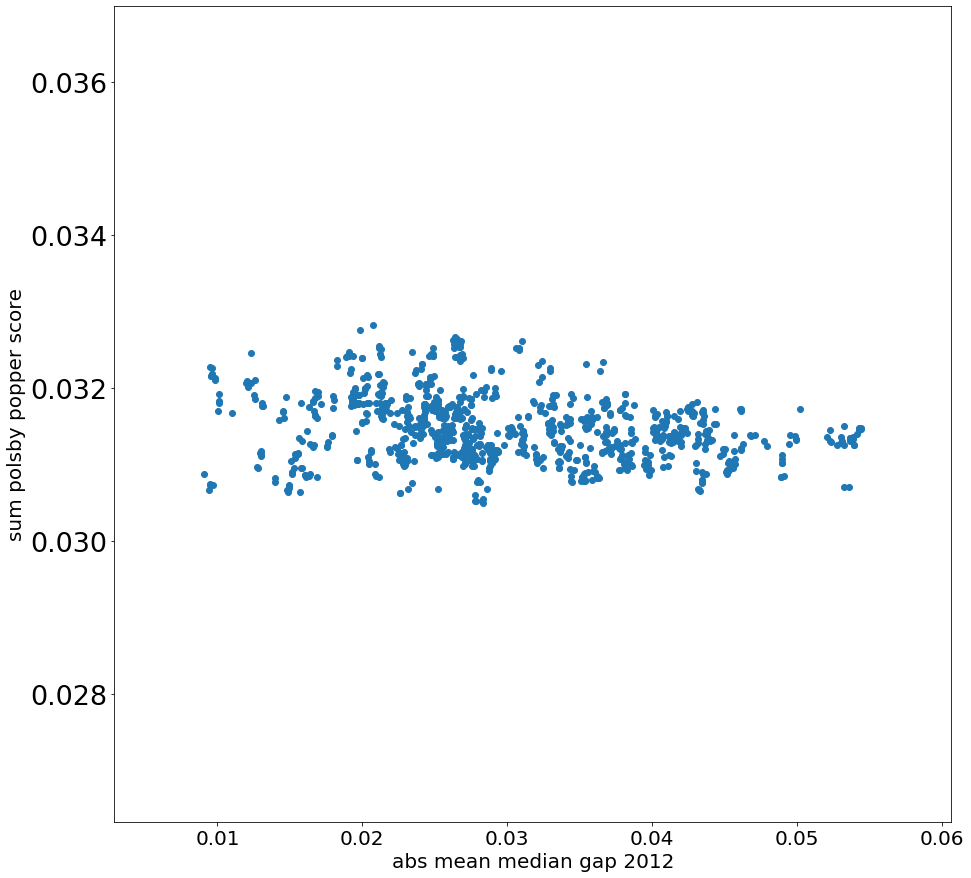

In [83]:
plt.figure(figsize=(15,15))
plt.scatter(MM_pres12, sum_pp_score)
plt.yticks(fontsize =27)
plt.xticks(fontsize =20)
plt.xlabel("abs mean median gap 2012",fontsize=20)
plt.ylabel("sum polsby popper score",fontsize=20)

In [84]:
perc_b_pop=[]
for i in range(1000):
    perc_b_pop.append([x/y for x,y in zip(B_pop[i],pop[i])])

In [85]:
max_perc_b_pop=[]
for i in range(1000):
    max_perc_b_pop.append(max(perc_b_pop[i]))

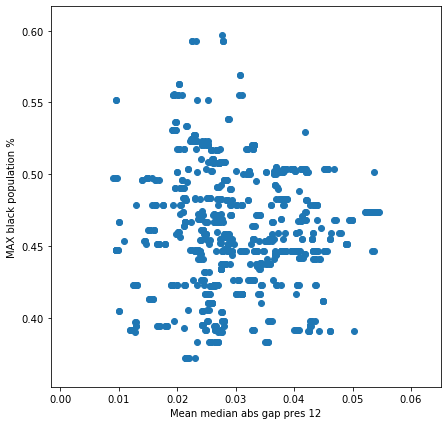

In [115]:
fig=plt.figure(figsize=(7,7))
plt.scatter(MM_pres12, max_perc_b_pop)
plt.yticks(fontsize =10)
plt.xticks(fontsize =10)
#plt.xlim(-0.001,0.005)
plt.xlabel("Mean median abs gap pres 12",fontsize=10)
plt.ylabel("MAX black population %",fontsize=10)
fig.savefig("PA_MM_BPOP.png")

Text(0, 0.5, 'MAX black population %')

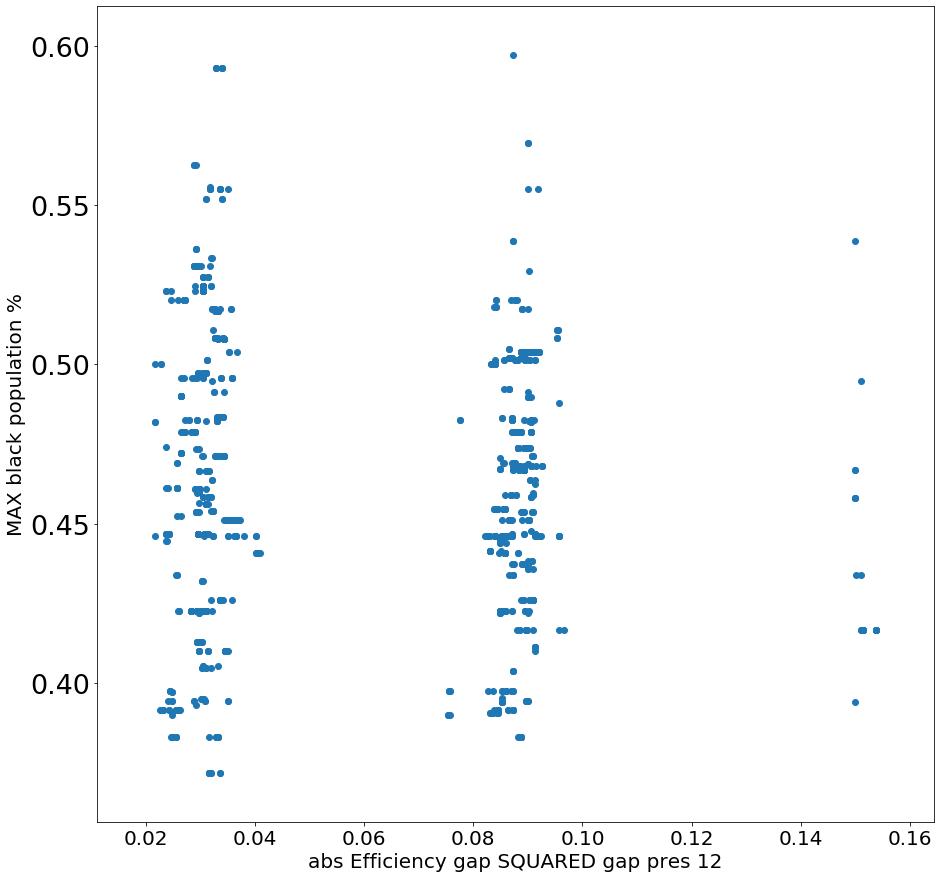

In [93]:
plt.figure(figsize=(15,15))
plt.scatter(EG_pres12, max_perc_b_pop)
plt.yticks(fontsize =27)
plt.xticks(fontsize =20)
plt.xlabel("abs Efficiency gap SQUARED gap pres 12",fontsize=20)
plt.ylabel("MAX black population %",fontsize=20)